## Parametric testing summary plots

In this notebook we investigate the consistency of the regression results over dimensionalities and across all sessions.

In [7]:
'''
Dependencies
'''
# General
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import scipy.io as sio
import pandas as pd
import numpy as np
import scipy
import random
import sys
import warnings 
from scipy import stats
warnings.simplefilter('ignore')
from matplotlib.patches import Patch
import statsmodels.api as sm
from tqdm import tqdm as pbar
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import importlib

# Utils and specific functions
from pyaldata import * 
sys.path.insert(0, '..') # rutils is in main folder directory
import rutils

# Plotting
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from rutils import *
import preprocess

sns.set_style('white')
cc = ['#416ae6', '#F25346', '#31AD6F', '#7FB8DA', '#6A695B', '#2A3146']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cc)
# green to blue ccycle
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#74E6A0', '#5FC49C', '#4AA298', '#348093', '#1F5E8F', '#0A3C8B'])

'''
Magic commands
'''
%config InlineBackend.figure_format = 'retina'

### Load data

In [8]:
sessions_C = ['Chewie_CO_VR_2016-09-09', 'Chewie_CO_VR_2016-09-12', 'Chewie_CO_VR_2016-09-14', 'Chewie_CO_VR_2016-10-06', 
              'Chewie_CO_FF_2016-09-15', 'Chewie_CO_FF_2016-09-21', 'Chewie_CO_FF_2016-10-05', 'Chewie_CO_FF_2016-10-07']

sessions_M = ['Mihili_CO_VR_2014-03-04', 'Mihili_CO_VR_2014-03-06', 'Mihili_CO_FF_2014-02-03', 'Mihili_CO_FF_2014-02-17', 
              'Mihili_CO_FF_2014-02-18', 'Mihili_CO_FF_2014-03-07', 'Mihili_CO_VR_2014-03-03']

m1_emap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'),  elecs=range(1,97))
pmd_emap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

### Run regressions for each session, for a range of PCs

In [9]:
warnings.simplefilter('ignore')

''' Pick sessions '''
sessions = sessions_M

''' Parameters '''
OTHER_ARRAY_D = 50 # Distance value to indicate other array
exp_var_levels = np.arange(0.2, 0.95, 0.025) # Choose explained variance levels

sessions_alphas = []
sessions_beta1 = []
sessions_beta2 = []

sessions_pvals_alpha = []
sessions_pvals_beta1 = []
sessions_pvals_beta2 = []
exp_var_to_pcs = []

for s in pbar(range(len(sessions))):

    # Load and preprocess session
    td = preprocess.preprocess_data(sessions[s], '/Users/Daphne/Data/')

    # Perform PCA on the trial concatenated trialdata
    td, model_both = tools.dim_reduce(td, PCA(n_components=td.both_rates[0].shape[1]), 'both_rates', 'both_pca', return_model=True)
    both_pcs = model_both.components_.T # shape (neurons x PCs)
    
    # Select a range of PCs for which to run OLS regressions, based on variance eplained
    components_range = [np.argmax(model_both.explained_variance_ratio_.cumsum() > exp_var_levels[i]) for i in range(len(exp_var_levels))]
    exp_var_to_pcs.append(components_range)
    alphas = []
    beta1 = []
    beta2 = []
    pvals_alpha = []
    pvals_beta1 = []
    pvals_beta2 = []
        
    for k in components_range:
        
        if k < 2: k += 1 # Can't compute correlation between two values

        L_emp = both_pcs[:, :k]

        # Compute correlations 
        C_emp, D_emp, A_emp = compute_stat_and_phys_distances(L_emp, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap)

        df_emp = pd.DataFrame(data={'correlation': C_emp, 'abs correlation': abs(C_emp), 'distance': D_emp, 'on array': A_emp})
        df_emp['category'] = df_emp['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))
        df_emp['within distance'] = pd.cut(df_emp['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

        # Perform ANOVA TEST (SINGLE category)
        X = np.vstack((np.ones_like(df_emp['correlation']), df_emp['distance'] == 0, df_emp['distance'] < OTHER_ARRAY_D)).T
        res = sm.OLS(df_emp['correlation'], X, hasconst=True).fit()

        # Store p values and beta coefficients
        alphas.append(res.params[0])
        beta1.append(res.params[1])
        beta2.append(res.params[2])

        pvals_alpha.append(res.pvalues[0])
        pvals_beta1.append(res.pvalues[1])
        pvals_beta2.append(res.pvalues[2])
        
    # store values of all pc ranges to session
    sessions_alphas.append(alphas)
    sessions_beta1.append(beta1)
    sessions_beta2.append(beta2)
    
    sessions_pvals_alpha.append(pvals_alpha)
    sessions_pvals_beta1.append(pvals_beta1)
    sessions_pvals_beta2.append(pvals_beta2)

sessions_pvals_alpha = np.array(sessions_pvals_alpha)
sessions_pvals_beta1 = np.array(sessions_pvals_beta1)
sessions_pvals_beta2 = np.array(sessions_pvals_beta2)

sessions_alphas = np.array(sessions_alphas)
sessions_beta1 = np.array(sessions_beta1)
sessions_beta2 = np.array(sessions_beta2)

 14%|█▍        | 1/7 [00:55<05:32, 55.34s/it]


KeyboardInterrupt: 

### Construct summary plot

In [6]:
from IPython.display import display, set_matplotlib_formats, HTML
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors

cs = ['#43D789', '#801607', '#8DB8ED', '#94B0B6', '#e42c12', '#005CA8', '#127340', '#111851']
# Color for False and True
cmap = matplotlib.colors.ListedColormap(['#ff9c8d', '#dafce3'])

sns.set(rc={ 'figure.figsize': (20, 10)})
sns.set_style('ticks', rc={ 'figure.facecolor': 'none', 'axes.facecolor': 'none' })
sns.set_context('notebook', rc={ 'lines.linewidth': 2.5 })

### Same electrode, same array, other array 

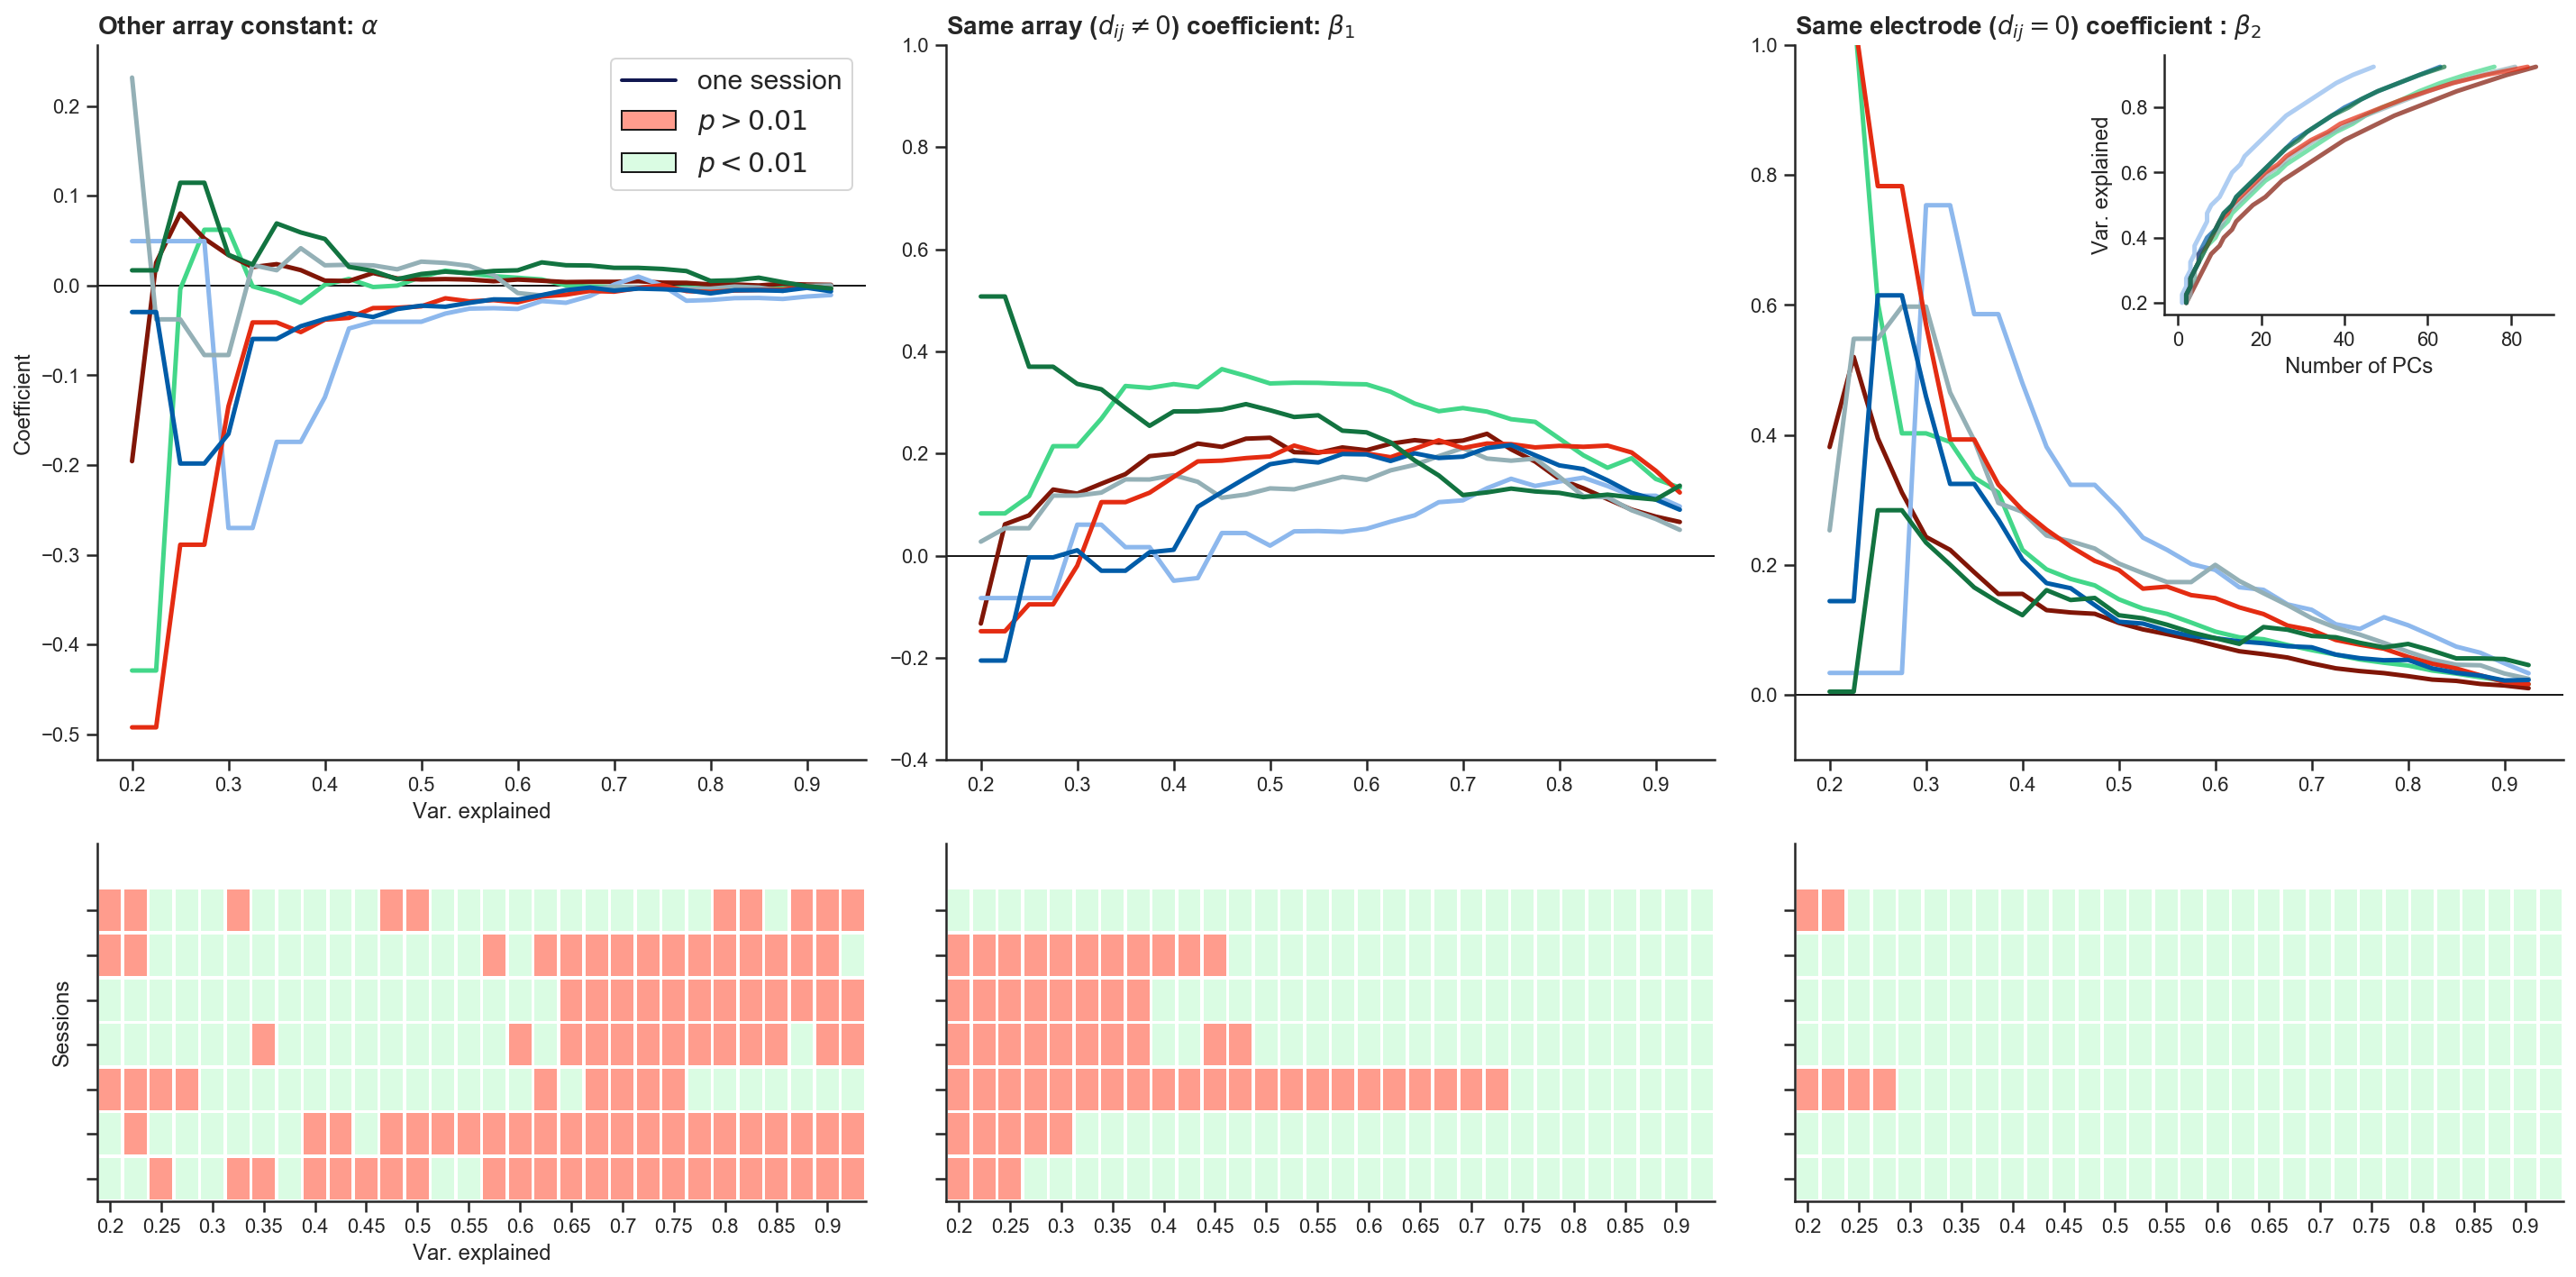

In [12]:
''' Make plot '''
fig, axs = plt.subplots(nrows=2, ncols=3, gridspec_kw={'height_ratios':[2, 1]})
label = [round(i, 2) for i in exp_var_levels]

#fig.suptitle('OLS regression coefficients across Monkey C sessions', y=1.03)

axs[0, 0].set_title(r'Other array constant: $\alpha$', loc='left', fontweight='bold', fontsize=14)
axs[0, 0].axhline(0, color='k', lw=1)
axs[0, 0].set_ylabel('Coefficient')
for i in range(sessions_beta2.shape[0]): axs[0, 0].plot(exp_var_levels, sessions_alphas[i, :], '-', color=cs[i])
#axs[0, 0].set_ylim([-0.1, 0.25])
axs[0, 0].set_xlabel('Var. explained')  

axs[0, 1].set_title(r'Same array ($d_{ij} \neq 0$) coefficient: $\beta_1$', fontweight='bold', loc='left', fontsize=14)
axs[0, 1].axhline(0, color='k', lw=1)
for i in range(sessions_beta2.shape[0]): axs[0, 1].plot(exp_var_levels, sessions_beta1[i, :] , '-', color=cs[i])
axs[0, 1].set_ylim([-0.4, 1])
    
axs[0, 2].set_title(r'Same electrode ($d_{ij} = 0$) coefficient : $\beta_2$', fontweight='bold', loc='left', fontsize=14)
axs[0, 2].axhline(0, color='k', lw=1)
axs[0, 2].set_ylim([-0.1, 1])
for i in range(sessions_beta2.shape[0]): axs[0, 2].plot(exp_var_levels, sessions_beta2[i, :] , '-', color=cs[i])

# Create inset at the default upper right location
axins = inset_axes(axs[0, 2], width=3, height=2)
#axins.tick_params(labelleft=False, labelbottom=False)
axins.set_xlabel('Number of PCs')
axins.set_ylabel('Var. explained')
for i in range(len(exp_var_to_pcs)): axins.plot(exp_var_to_pcs[i], exp_var_levels, '-', color=cs[i], alpha=0.7)
    
sns.heatmap(sessions_pvals_alpha < 0.01, cmap=cmap, linewidths=1.3, cbar=False, ax=axs[1, 0])
axs[1, 0].set_ylim([0, 8]) # set the ylim to bottom, top
axs[1, 0].set_xlabel('Var. explained')    
axs[1, 0].set_xticklabels(label[::2], fontsize=11)
axs[1, 0].set_yticklabels([])
axs[1, 0].set_ylabel('Sessions')
    
sns.heatmap(sessions_pvals_beta1 < 0.01, cmap=cmap, linewidths=1.3, cbar=False, ax=axs[1, 1])
axs[1, 1].set_ylim([0, 8]) # set the ylim to bottom, top
axs[1, 1].set_xticklabels(label[::2], fontsize=11)
axs[1, 1].set_yticklabels([])
    
sns.heatmap(sessions_pvals_beta2 < 0.01, cmap=cmap, linewidths=1.3, cbar=False, ax=axs[1, 2])
axs[1, 2].set_ylim([0, 8]) # set the ylim to bottom, top
axs[1, 2].set_xticklabels(label[::2], fontsize=11)
axs[1, 2].set_yticklabels([])

legend_elements = [Line2D([0], [0], color=cs[7], lw=2, label='one session'),
                   Patch(facecolor='#ff9c8d', edgecolor='k', label=r'$p > 0.01$'),
                   Patch(facecolor='#dafce3', edgecolor='k', label=r'$p < 0.01$'),]
axs[0, 0].legend(handles=legend_elements, prop={'size': 15})

fig.tight_layout(), sns.despine();